In [11]:
import tensorflow as tf
import os
from datetime import datetime
import matplotlib.pyplot as plt
import sys
import copy

sys.path.insert(0, '../training')
from shared_funcs import multi_label_binary_encode_tensor, multi_label_binary_decode_tensor, get_waveform

In [12]:
INPUT_AUDIO_DIR = os.path.dirname(os.getcwd()) + "/data-manipulation/supp/input/audio/"
INPUT_META_DIR = os.path.dirname(os.getcwd()) + "/data-manipulation/supp/input/metadata/"

if not os.path.exists(INPUT_AUDIO_DIR):
    os.makedirs(INPUT_AUDIO_DIR)
if not os.path.exists(INPUT_META_DIR):
    os.makedirs(INPUT_META_DIR)

## Define functions
Mainly pulled from model.ipynb

In [13]:
ALL_LABELS = tf.constant(['Rctrl', 'p', 'esc', 'g', 'slash', 'down', '7', 'equal', 'w', 'a', 'dash', 'caps', 'l', 'd', 'backspace', 'bracketclose', 'z', '1', 'end', 'Rshift', 'comma', 'c', 'tab', 'b', 'j', 'right', 'Lctrl', 'n', 't', 'f', 'm', 'o', 'apostrophe', 'y', '8', 'space', 'backslash', 's', '9', 'i', 'r', 'bracketopen', 'semicolon', 'q', '5', 'k', '3', 'x', '4', '6', '2', 'Lshift', 'left', 'backtick', 'enter', 'fullstop', 'e', '0', 'h', 'v', 'up', 'u', 'delete'], dtype=tf.string)

In [14]:
def load_audio_data():
    data = []
    for file in os.listdir(INPUT_AUDIO_DIR):
        split_fn = file.split("-")
        split_fn[1] = split_fn[1][:-4] # Remove .wav extension
        split_fn[0] = float(split_fn[0])
        split_fn[1] = float(split_fn[1])
        data.append({"start_time": datetime.fromtimestamp(split_fn[0]),
                      "end_time": datetime.fromtimestamp(split_fn[1]),
                        "waveform": get_waveform(INPUT_AUDIO_DIR + file)
        })
    
    return data

def loadMetadata():
    metadata = []
    for file in os.listdir(INPUT_META_DIR):
        with open(INPUT_META_DIR + file, "r") as file:
            fdata = file.readlines()

        for line in fdata:
            line = line.strip("\n").split(",")
            metadata.append({"label": multi_label_binary_encode_tensor(line[0]), "time": datetime.fromtimestamp(float(line[1]))})
    return metadata

# Remove keypresses keylogged outside of recording time
def filterMetadata(audio_data, metadata):
    filtered_metadata = []
    for mdata in metadata:
        for audio_ts in audio_data:
            start_time = audio_ts["start_time"]
            end_time = audio_ts["end_time"]
            timestamp = mdata["time"]
            if start_time <= timestamp <= end_time:
                filtered_metadata.append(mdata)
    return filtered_metadata

def matchMetadataToAudioSlice(audio_slice, metadata):
    matched_metadata = []
    start_time = audio_slice["start_time"]
    end_time = audio_slice["end_time"]

    for mdata in metadata:
        mdata_ts = mdata["time"]
        if start_time <= mdata_ts <= end_time:
            matched_metadata.append(mdata)

    return matched_metadata

## Load Raw Data

In [15]:
audio_data = load_audio_data()
metadata = filterMetadata(audio_data, loadMetadata())

## Audio Preprocessing
Audio Normalization 

In [16]:
# Normalize waveform
def normalize_peak(waveform):
    max_amplitude = tf.reduce_max(tf.abs(waveform))
    return waveform / max_amplitude

# Normalize raw audio data
normalized_audio_data = []
for sample in audio_data:
    sample_copy = copy.deepcopy(sample)
    sample_copy["waveform"] = normalize_peak(sample_copy["waveform"])
    normalized_audio_data.append(sample_copy)

Data Augmentation

In [17]:
def add_noise(waveform, noise_level):
    noise = tf.random.normal(tf.shape(waveform), stddev=noise_level)
    return waveform + noise

def augment_volume(waveform, gain_db):
    gain = 10 ** (gain_db / 20.0)
    return waveform * gain

def augment_waveform(waveform):
    waveform = add_noise(waveform, 0.02)
    waveform = augment_volume(waveform, tf.random.uniform([], -2.0, 2.0))
    return waveform

# Augment the normalized audio data
augmented_audio_data = []
for sample in normalized_audio_data:
    # Take copy of normalized_audio_data
    sample_copy = copy.deepcopy(sample)
    
    sample_copy["waveform"] = augment_waveform(sample_copy["waveform"])
    augmented_audio_data.append(sample_copy)

## Spectrogram Generation

In [18]:
def compute_spectrograms(audio_sample, frame_length=2205, frame_step=1102):
    
    spectrogram = tf.signal.stft(
        audio_sample,
        frame_length=frame_length,
        frame_step=frame_step,
        fft_length=frame_length
    )

    # Compute magnitude of STFT (Spectrogram)
    spectrogram_magnitude = tf.abs(spectrogram)

    # Normalize spectrogram
    spectrogram_magnitude = tf.math.log(spectrogram_magnitude + 1e-6)  

    # print("STFT Spectrogram Shape:", spectrogram_magnitude.shape)
    return spectrogram_magnitude



# Takes one entry of audio_data and all entries of meta_data and returns a tensor of spectrograms and labels
def generate_spectrogram_and_label(audio_data, meta_data):
    sample_rate = 44100
    frame_length = 2205
    frame_step = 1102
    tolerance_sec = 0.05 # 50 ms


    spectrograms = compute_spectrograms(audio_data["waveform"], frame_length, frame_step)
    num_windows = tf.shape(spectrograms)[0]

    frame_time_ranges = [
        (i * frame_step / sample_rate, (i * frame_step + frame_length) / sample_rate)
        for i in range(num_windows)
    ]

    spectrogram_labels = []
    for frame_start, frame_end in frame_time_ranges:
        frame_labels_binary = tf.zeros(len(ALL_LABELS), dtype=tf.int32)  # Default zero tensor

        for label_data in metadata:
            label_time = (label_data["time"] - audio_data["start_time"]).total_seconds()
            if (frame_start - tolerance_sec) <= label_time <= (frame_end + tolerance_sec):
                label_index = tf.where(ALL_LABELS == multi_label_binary_decode_tensor(label_data["label"]))
                if tf.size(label_index) > 0:
                    frame_labels_binary = tf.tensor_scatter_nd_update(
                        frame_labels_binary,
                        indices=[[label_index[0][0]]],
                        updates=[1]
                    )

        spectrogram_labels.append(frame_labels_binary)
    
    spectrogram_labels = tf.stack(spectrogram_labels) # Convert to tensor

    return spectrograms, spectrogram_labels

audio_data = load_audio_data()
metadata = filterMetadata(audio_data, loadMetadata())

## Create Dataset

In [19]:
def create_dataset(audio_data, metadata):
    def gen():
        for audio_slice in audio_data:
            spectrograms, labels = generate_spectrogram_and_label(audio_slice, metadata)
            yield spectrograms, labels

    output_signature = (
        tf.TensorSpec(shape=(39, 1103), dtype=tf.float32),  # Data shape and dtype
        tf.TensorSpec(shape=(39, 63), dtype=tf.int32)         # Label shape and dtype
    )
    # Create a dataset from the generator
    dataset = tf.data.Dataset.from_generator(gen, output_signature=output_signature)
    
    return dataset

In [20]:
merged_audio_data = audio_data + augmented_audio_data
dataset = create_dataset(merged_audio_data, metadata)
dataset = dataset.prefetch(tf.data.AUTOTUNE)
dataset.cache()


dataset_size = dataset.reduce(0, lambda x, _: x + 1).numpy()

dataset = dataset.shuffle(buffer_size=dataset_size)
print(dataset.element_spec)
print("Dataset Size: ", dataset_size)

(TensorSpec(shape=(39, 1103), dtype=tf.float32, name=None), TensorSpec(shape=(39, 63), dtype=tf.int32, name=None))
Dataset Size:  16


## Preview Data

#### Waveform Peak Normalization

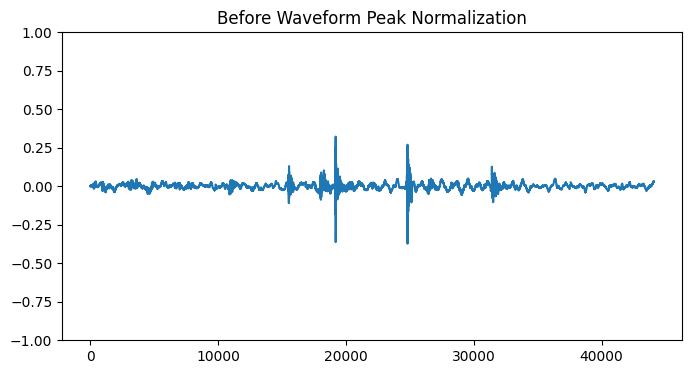

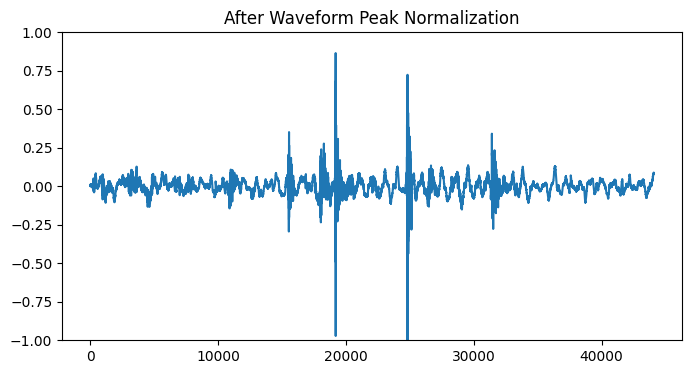

In [21]:
plt.figure(figsize=(8, 4))
plt.title("Before Waveform Peak Normalization")
plt.ylim(-1, 1)
plt.plot(audio_data[0]["waveform"].numpy())

plt.figure(figsize=(8, 4))
plt.title("After Waveform Peak Normalization")
plt.ylim(-1, 1)
plt.plot(normalized_audio_data[0]["waveform"].numpy())

#### Waveform Data Augmentation

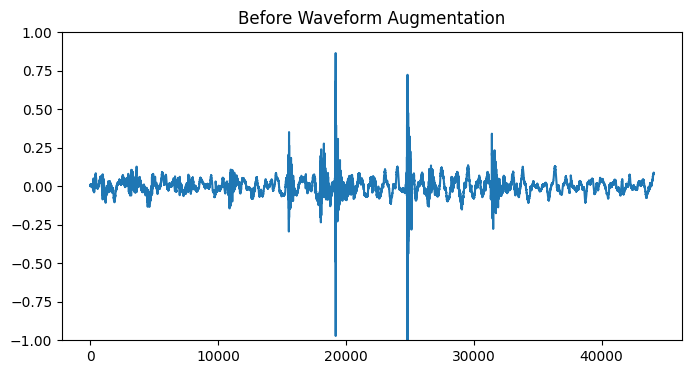

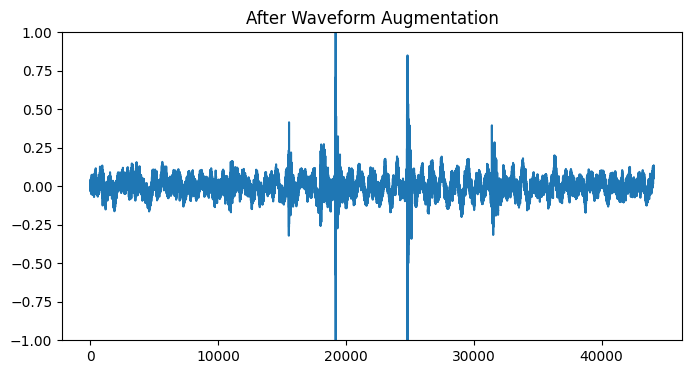

In [22]:
plt.figure(figsize=(8, 4))
plt.title("Before Waveform Augmentation")
plt.ylim(-1, 1)
plt.plot(normalized_audio_data[0]["waveform"].numpy())

plt.figure(figsize=(8, 4))
plt.title("After Waveform Augmentation")
plt.ylim(-1, 1)
plt.plot(augmented_audio_data[0]["waveform"].numpy())

#### Spectrograms

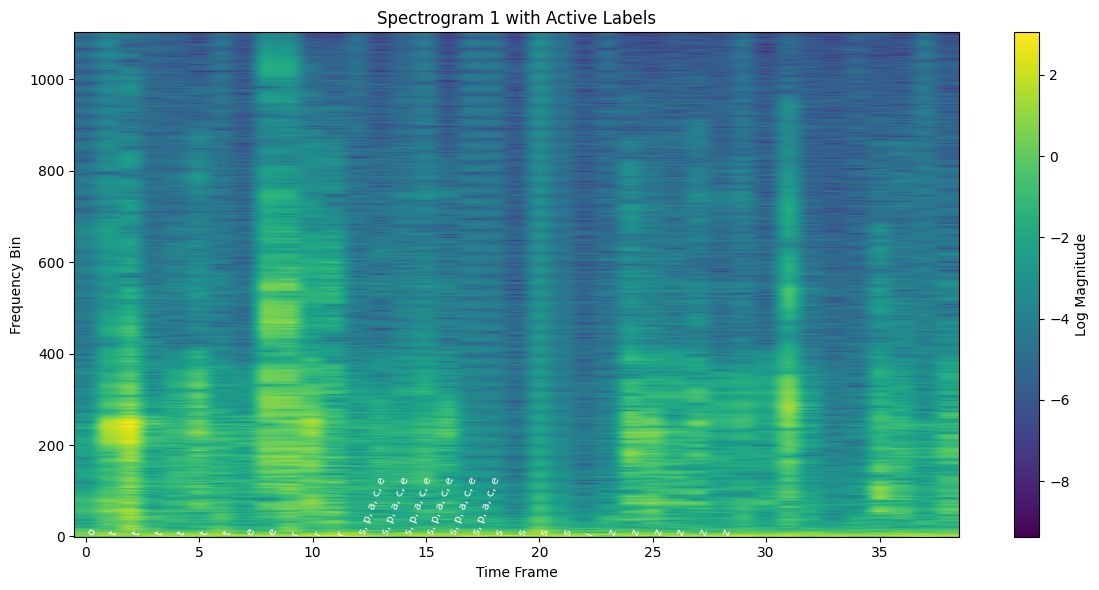

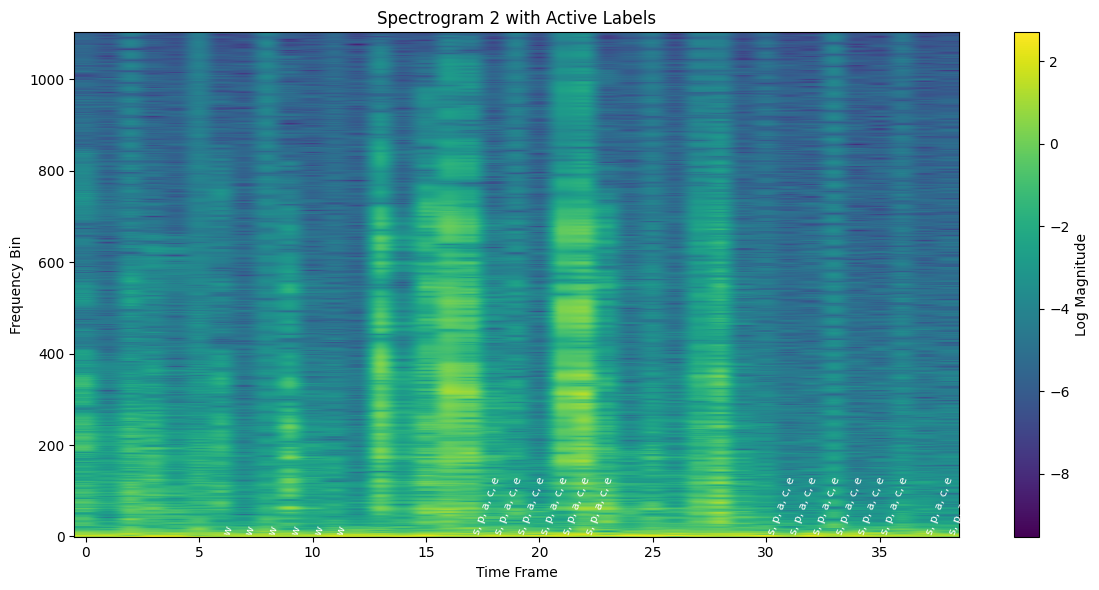

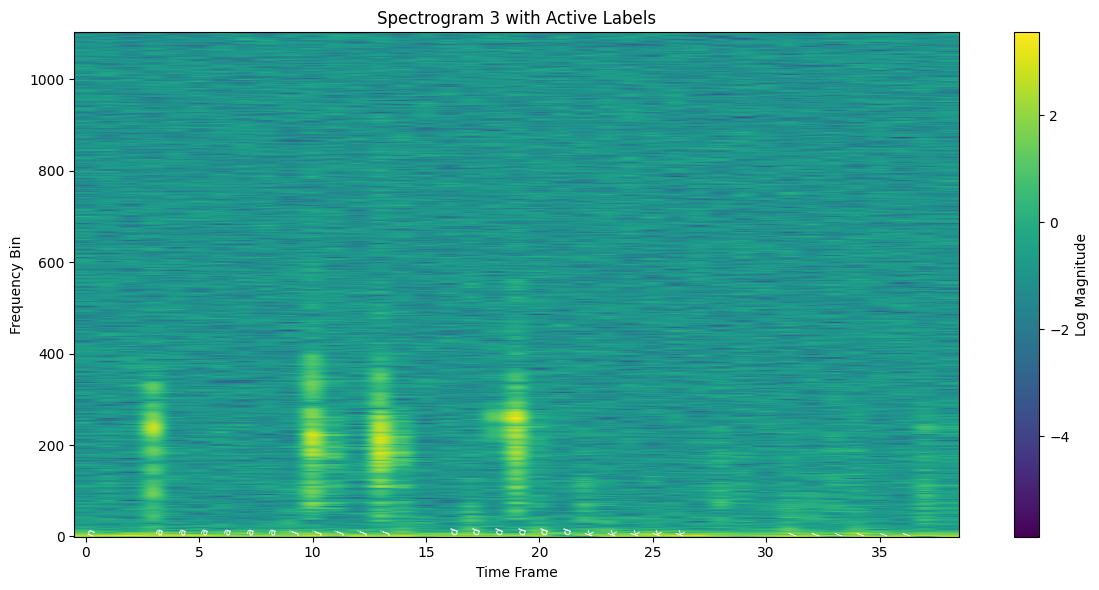

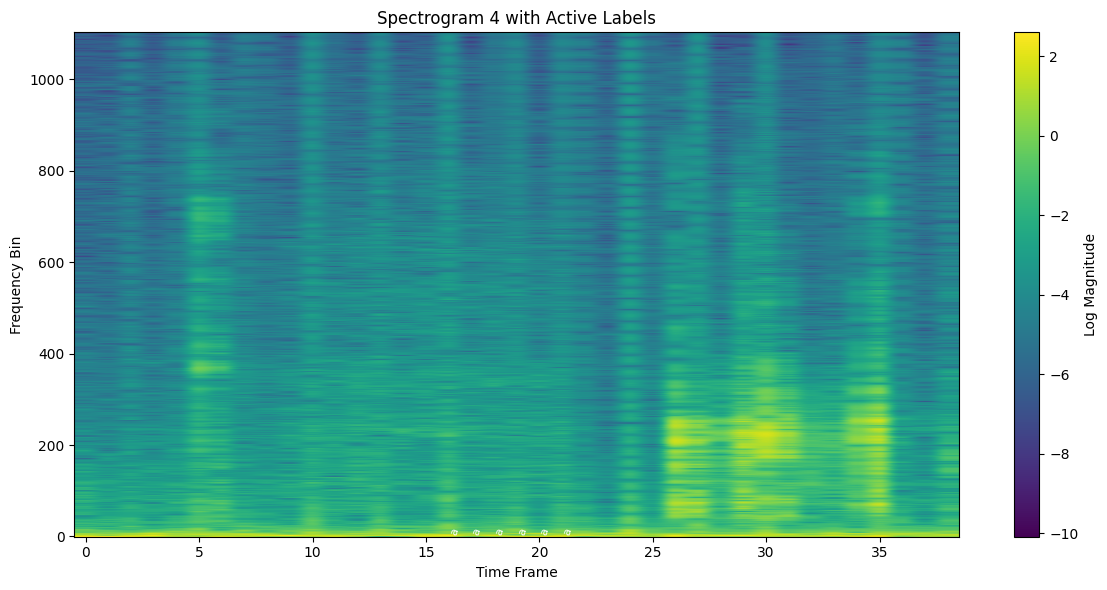

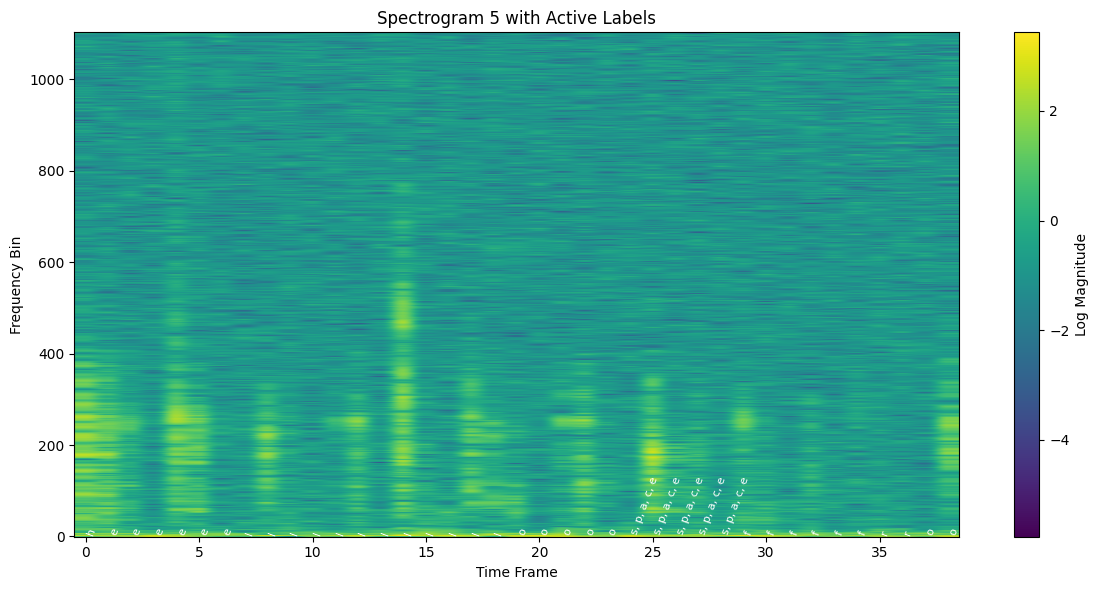

2024-12-04 18:26:09.628301: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [23]:
def plot_spectrogram_with_decoded_labels(dataset, num_examples=5):
    for i, (spectrogram, labels) in enumerate(dataset.take(num_examples)):
        plt.figure(figsize=(12, 6))
        
        # Plot the spectrogram
        plt.imshow(tf.transpose(spectrogram).numpy(), aspect='auto', origin='lower', cmap='viridis')
        plt.colorbar(label='Log Magnitude')
        plt.title(f'Spectrogram {i + 1} with Active Labels')
        plt.xlabel('Time Frame')
        plt.ylabel('Frequency Bin')
        
        # Iterate through each time frame
        labels_np = labels.numpy()
        for time_step in range(labels_np.shape[0]):
            binary_vector = labels_np[time_step]
            active_classes = multi_label_binary_decode_tensor(binary_vector)
            if len(active_classes) != 0:
                active_classes = str(active_classes[0].numpy().decode("UTF-8"))
            # print(active_classes)
            
            if active_classes:  # Annotate
                plt.text(
                    time_step, 0, ", ".join(active_classes),
                    rotation=70, fontsize=8, color='white', va='bottom'
                )
        
        plt.tight_layout()
        plt.show()

plot_spectrogram_with_decoded_labels(dataset, num_examples=5)

## Save new dataset

In [24]:
path = os.path.dirname(os.getcwd()) + "/data-manipulation/supp_dataset"

dataset.save(path)